### Compare theoretical and ground state energy at unit filling

In [1032]:
import numpy as np
import bisect
import matplotlib.pyplot as plt
import pimc # custom module
from scipy.stats import truncexpon
from scipy.integrate import quad, simps
import importlib
importlib.reload(pimc)

<module 'pimc' from '/Users/ecasiano/Desktop/LatticePIMC/src/pimc.py'>

### Simulation parameters

In [1033]:
importlib.reload(pimc)
# Simulation parameters
t = 1.0
mu = 1.0
U = 5 # Leave this fixed
L = 4
N = 4

# PIMC parameters
beta = 1
eta = 1/np.sqrt(L*beta) # worm end fugacity
dtau = 0.4999999*beta # Set neighborhood of beta/2 where <K> will be measured

# Canonical or Grand Canonical?
canonical = False # False means Grand Canonical

# Create a random worldline configuration
alpha = pimc.random_boson_config(L,N)
alpha = [1]*L
data_struct = pimc.create_data_struct(alpha,L)
head_loc = []
tail_loc = []
#pimc.view_worldlines(data_struct,beta,figure_name=None)

### Do many iterations of the set of PIMC-WA updates

In [1034]:
importlib.reload(pimc)

# Create the data structure
data_struct = pimc.create_data_struct(alpha,L)
head_loc = []
tail_loc = []

# Store values of observables
Z_ctr = 0 # Count configurations with no worm ends
diagonal_list = []
kinetic_list = []
N_list = [] # average total particles 
occ_list = [] # average particle occupation
E_N_list = [] # Fixed total particle energies
E_canonical_list = [] # To save energies only for N space configurations

# Counters for acceptance of each move
insert_worm_data = [0,0] # [accepted,proposed]
delete_worm_data = [0,0]

insert_anti_data = [0,0]
delete_anti_data = [0,0]

advance_head_data = [0,0]
recede_head_data = [0,0]

advance_tail_data = [0,0]
recede_tail_data = [0,0]

insertZero_worm_data = [0,0]
deleteZero_worm_data = [0,0]

insertZero_anti_data = [0,0]
deleteZero_anti_data = [0,0]

insertBeta_worm_data = [0,0]
deleteBeta_worm_data = [0,0]

insertBeta_anti_data = [0,0]
deleteBeta_anti_data = [0,0]

ikbh_data = [0,0]
dkbh_data = [0,0]

ikah_data = [0,0]
dkah_data = [0,0]

ikbt_data = [0,0]
dkbt_data = [0,0]

ikat_data = [0,0]
dkat_data = [0,0]

In [1035]:
%%time

# Set the number of times the set of updates will be attempted
mc_steps = int(2.5E+05)
for m in range(mc_steps):
    
    # Non-Spaceshift moves
    result = pimc.worm_insert(data_struct,beta,head_loc,tail_loc,U,mu,eta,L,N,canonical,insert_worm_data,insert_anti_data)

    result = pimc.worm_delete(data_struct,beta,head_loc,tail_loc,U,mu,eta,L,N,canonical,delete_worm_data,delete_anti_data)
    
    result = pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc,U,mu,L,N,canonical,advance_head_data,recede_head_data,advance_tail_data,recede_tail_data)
        
    result = pimc.insertZero(data_struct,beta,head_loc,tail_loc,U,mu,eta,L,N,canonical,insertZero_worm_data,insertZero_anti_data)
        
    result = pimc.deleteZero(data_struct,beta,head_loc,tail_loc,U,mu,eta,L,N,canonical,deleteZero_worm_data,deleteZero_anti_data)
    
    result = pimc.insertBeta(data_struct,beta,head_loc,tail_loc,U,mu,eta,L,N,canonical,insertBeta_worm_data,insertBeta_anti_data)
        
    result = pimc.deleteBeta(data_struct,beta,head_loc,tail_loc,U,mu,eta,L,N,canonical,deleteBeta_worm_data,deleteBeta_anti_data)
  
    
    # Spaceshift moves   
    result = pimc.insert_kink_before_head(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,L,N,canonical,ikbh_data)  
        
    result = pimc.delete_kink_before_head(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,L,N,canonical,dkbh_data) 
     
        
    result = pimc.insert_kink_after_head(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,L,N,canonical,ikah_data)   
        
    result = pimc.delete_kink_after_head(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,L,N,canonical,dkah_data)
    
    
    result = pimc.insert_kink_before_tail(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,L,N,canonical,ikbt_data)  
        
    result = pimc.delete_kink_before_tail(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,L,N,canonical,dkbt_data) 
    
    
    result = pimc.insert_kink_after_tail(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,L,N,canonical,ikat_data)   
        
    result = pimc.delete_kink_after_tail(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,L,N,canonical,dkat_data)
        
    # Calculate observables when there are no worms present
    if m >= 0.30*mc_steps and m%L==0: # Ignore unequilibrated data
        
        if not(pimc.check_worm(head_loc,tail_loc)):
            
            # Count diagonal configurations
            Z_ctr += 1
            
            # Calculate kinetic, diagonal, and total energy
            kinetic,diagonal = pimc.bh_egs(data_struct,beta,dtau,U,mu,t,L)
            diagonal_list.append(diagonal)
            kinetic_list.append(kinetic)
            
            # Calculate the average total number of particles
            N_list.append(pimc.n_pimc(data_struct,beta,L)) # <n>
            
            # Calculate the average particle occupation
            occ_list.append(pimc.n_i_pimc(data_struct,beta,L))
           
            # Build histogram of fixed total particle energies E_N
            N_current = int(round(pimc.N_tracker(data_struct,beta,L)))
            E_current = kinetic+diagonal # total energy at this iteration
            E_N_list.append((E_current,N_current))
            if N_current == N:
                E_canonical_list.append(E_current)

CPU times: user 33.7 s, sys: 258 ms, total: 34 s
Wall time: 34.1 s


In [1036]:
# Acceptance ratios
print("\n-------- Acceptance Ratios --------\n")

print("       Insert worm: %.4f%% (%d/%d)"%(100*insert_worm_data[0]/insert_worm_data[1],insert_worm_data[0],insert_worm_data[1]))
print("       Delete worm: %.4f%% (%d/%d)\n"%(100*delete_worm_data[0]/delete_worm_data[1],delete_worm_data[0],delete_worm_data[1]))

print("       Insert anti: %.4f%% (%d/%d)"%(100*insert_anti_data[0]/insert_anti_data[1],insert_anti_data[0],insert_anti_data[1]))
print("       Delete anti: %.4f%% (%d/%d)\n"%(100*delete_anti_data[0]/delete_anti_data[1],delete_anti_data[0],delete_anti_data[1]))

print("       Advance head: %.4f%% (%d/%d)"%(100*advance_head_data[0]/advance_head_data[1],advance_head_data[0],advance_head_data[1]))
print("        Recede head: %.4f%% (%d/%d)\n"%(100*recede_head_data[0]/recede_head_data[1],recede_head_data[0],recede_head_data[1]))

print("       Advance tail: %.4f%% (%d/%d)"%(100*advance_tail_data[0]/advance_tail_data[1],advance_tail_data[0],advance_tail_data[1]))
print("        Recede tail: %.4f%% (%d/%d)\n"%(100*recede_tail_data[0]/recede_tail_data[1],recede_tail_data[0],recede_tail_data[1]))

print("   InsertZero worm: %.4f%% (%d/%d)"%(100*insertZero_worm_data[0]/insertZero_worm_data[1],insertZero_worm_data[0],insertZero_worm_data[1]))
print("   DeleteZero worm: %.4f%% (%d/%d)\n"%(100*deleteZero_worm_data[0]/deleteZero_worm_data[1],deleteZero_worm_data[0],deleteZero_worm_data[1]))

print("   InsertZero anti: %.4f%% (%d/%d)"%(100*insertZero_anti_data[0]/insertZero_anti_data[1],insertZero_anti_data[0],insertZero_anti_data[1]))
print("   DeleteZero anti: %.4f%% (%d/%d)\n"%(100*deleteZero_anti_data[0]/deleteZero_anti_data[1],deleteZero_anti_data[0],deleteZero_anti_data[1]))

print("   InsertBeta worm: %.4f%% (%d/%d)"%(100*insertBeta_worm_data[0]/insertBeta_worm_data[1],insertBeta_worm_data[0],insertBeta_worm_data[1]))
print("   DeleteBeta worm: %.4f%% (%d/%d)\n"%(100*deleteBeta_worm_data[0]/deleteBeta_worm_data[1],deleteBeta_worm_data[0],deleteBeta_worm_data[1]))

print("   InsertBeta anti: %.4f%% (%d/%d)"%(100*insertBeta_anti_data[0]/insertBeta_anti_data[1],insertBeta_anti_data[0],insertBeta_anti_data[1]))
print("   DeleteBeta anti: %.4f%% (%d/%d)\n"%(100*deleteBeta_anti_data[0]/deleteBeta_anti_data[1],deleteBeta_anti_data[0],deleteBeta_anti_data[1]))

print("              IKBH: %.4f%% (%d/%d)"%(100*ikbh_data[0]/ikbh_data[1],ikbh_data[0],ikbh_data[1])) 
print("              DKBH: %.4f%% (%d/%d)\n"%(100*dkbh_data[0]/dkbh_data[1],dkbh_data[0],dkbh_data[1]))

print("              IKAH: %.4f%% (%d/%d)"%(100*ikah_data[0]/ikah_data[1],ikah_data[0],ikah_data[1])) 
print("              DKAH: %.4f%% (%d/%d)\n"%(100*dkah_data[0]/dkah_data[1],dkah_data[0],dkah_data[1])) 

print("              IKBT: %.4f%% (%d/%d)"%(100*ikbt_data[0]/ikbt_data[1],ikbt_data[0],ikbt_data[1])) 
print("              DKBT: %.4f%% (%d/%d)\n"%(100*dkbt_data[0]/dkbt_data[1],dkbt_data[0],dkbt_data[1]))

print("              IKAT: %.4f%% (%d/%d)"%(100*ikat_data[0]/ikat_data[1],ikat_data[0],ikat_data[1])) 
print("              DKAT: %.4f%% (%d/%d)\n"%(100*dkat_data[0]/dkat_data[1],dkat_data[0],dkat_data[1])) 


-------- Acceptance Ratios --------

       Insert worm: 55.3908% (20622/37230)
       Delete worm: 79.4225% (19943/25110)

       Insert anti: 47.3882% (17736/37427)
       Delete anti: 90.6272% (18884/20837)

       Advance head: 100.0000% (44175/44175)
        Recede head: 100.0000% (43714/43714)

       Advance tail: 100.0000% (43086/43086)
        Recede tail: 100.0000% (43899/43899)

   InsertZero worm: 51.4924% (63676/123661)
   DeleteZero worm: 63.2741% (63531/100406)

   InsertZero anti: 58.8476% (61388/104317)
   DeleteZero anti: 55.4980% (61242/110350)

   InsertBeta worm: 51.3769% (64010/124589)
   DeleteBeta worm: 63.1202% (63687/100898)

   InsertBeta anti: 58.9671% (60745/103015)
   DeleteBeta anti: 55.2784% (60421/109303)

              IKBH: 52.9815% (52635/99346)
              DKBH: 82.3655% (52111/63268)

              IKAH: 36.9658% (36724/99346)
              DKAH: 85.9276% (37235/43333)

              IKBT: 37.0289% (36469/98488)
              DKBT: 86.1152% (370

### Process data

N_check:  3.0


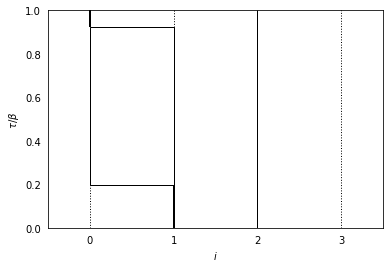

In [1037]:
print("N_check: ",pimc.N_tracker(data_struct,beta,L))
pimc.view_worldlines(data_struct,beta,figure_name=None)

In [1038]:
diagonal = np.mean(diagonal_list)
kinetic = np.mean(kinetic_list)
N_mean = np.mean(N_list)
E_canonical = np.mean(E_canonical_list)
occ = np.mean(occ_list,axis=0)
print(Z_ctr)

13048


In [1039]:
importlib.reload(pimc)
print("Samples: %d"%Z_ctr)
print("-------- Ground State Energy (E/t) --------")
print("PIMC: %.8f"%((diagonal+kinetic)/t))
print("-------- (canonical) Ground State Energy (E/t) --------")
print("PIMC: %.8f"%((E_canonical)/t))
print("-------- Average particles per site --------")
print("PIMC: %.8f"%(N_mean/L))
print("-------- Average occupation --------")
print("PIMC:",occ)
print("-------- Z-configuration fraction --------")
print("Z-fraction: %.2f%%"%(Z_ctr/mc_steps*100))

Samples: 13048
-------- Ground State Energy (E/t) --------
PIMC: -4.45516554
-------- (canonical) Ground State Energy (E/t) --------
PIMC: -5.16769622
-------- Average particles per site --------
PIMC: 0.83466815
-------- Average occupation --------
PIMC: [0.83813611 0.83905579 0.82150521 0.83997548]
-------- Z-configuration fraction --------
Z-fraction: 5.22%


### Fixed total particle (E_N) energy histogram

In [1040]:
from collections import OrderedDict
# reference: https://stackoverflow.com/a/51491688

d = OrderedDict()
for en,n in E_N_list: # en: energy, n: total particle number
    d.setdefault(n, []).append(en)
    
d = [(sum(v) / len(v), k) for k, v in d.items()]

d = sorted(d,key=lambda x: x[1])

In [1041]:
print("\n-------- Average energy of fixed N sectors (E_N/t) --------")
for i in range(len(d)):
        print("E_%i/t: %.2f"%(d[i][1],d[i][0]/t))


-------- Average energy of fixed N sectors (E_N/t) --------
E_0/t: 0.00
E_1/t: -1.80
E_2/t: -3.28
E_3/t: -4.44
E_4/t: -5.17
E_5/t: -2.40
E_6/t: 0.44


In [1042]:
len(E_canonical_list)

5504

In [1043]:
Z_ctr

13048

### Save data

In [1044]:
E_canonical_list = np.array(E_canonical_list)
with open("egsCAN_%i_%i_%.4f_%.4f__%.4f_%.4f_%i.dat"%(L,N,U,mu,t,eta,mc_steps),"w+") as data:
    np.savetxt(data,E_canonical_list,delimiter=",",fmt="%.16f",header="MC_step <E_canonical> // BH Parameters: L=%d,N=%d,U=%.4f,mu=%.4f,t=%.4f,eta=%.4f,MC_steps=%i"%(L,N,U,mu,t,eta,mc_steps))

egs_list = np.array(egs_list)
with open("egs_%i_%i_%.4f_%.4f_%.4f_%i.dat"%(L,N,U,mu,eta,mc_steps),"w+") as data:
    np.savetxt(data,egs_list,delimiter=",",fmt="%.16f",header="MC_step <E> // BH Parameters: L=%d,N=%d,U=%.8f,mu=%.8f,eta=%.8f,MC_steps=%i"%(L,N,U,mu,eta,mc_steps))
    
n_list = np.array(n_list)
with open("n_%i_%i_%.4f_%.4f_%.4f_%i.dat"%(L,N,U,mu,eta,mc_steps),"w+") as data:
    np.savetxt(data,n_list,delimiter=",",fmt="%.16f",header="MC_step <n> // BH Parameters: L=%d,N=%d,U=%.8f,mu=%.8f,eta=%.8f,MC_steps=%i"%(L,N,U,mu,eta,mc_steps))
    
occ_list = np.array(occ_list)
with open("occ_%i_%i_%.4f_%.4f_%.4f_%i.dat"%(L,N,U,mu,eta,mc_steps),"w+") as data:
    np.savetxt(data,occ_list,delimiter=",",fmt="%.16f",header="MC_step <n_i> // BH Parameters: L=%d,N=%d,U=%.8f,mu=%.8f,eta=%.8f,MC_steps=%i"%(L,N,U,mu,eta,mc_steps))    

NameError: name 'egs_list' is not defined